In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense
from tensorflow.keras.utils import to_categorical

In [11]:
# Load KMNIST dataset with information
(ds_train, ds_test), ds_info = tfds.load('kmnist', split=['train[:1%]', 'test'], as_supervised=True, with_info=True)

# Access the first batch in the training set
for img, label in ds_train.take(1):
    print("Image Shape:", img.shape)
    print("Label:", label)

Image Shape: (28, 28, 1)
Label: tf.Tensor(9, shape=(), dtype=int64)


In [12]:
Temp = ds_train
ds_train = ds_test
ds_test = Temp

In [15]:
train_images, train_labels = [], []
test_images, test_labels = [], []

for img, label in ds_train:
    train_images.append(img.numpy())
    train_labels.append(label.numpy())

for img, label in ds_test:
    test_images.append(img.numpy())
    test_labels.append(label.numpy())

X_train = tf.convert_to_tensor(train_images, dtype=tf.float32)
y_train = tf.convert_to_tensor(train_labels, dtype=tf.int64)

X_test = tf.convert_to_tensor(test_images, dtype=tf.float32)
y_test = tf.convert_to_tensor(test_labels, dtype=tf.int64)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (10000, 28, 28, 1)
y_train shape: (10000,)
X_test shape: (600, 28, 28, 1)
y_test shape: (600,)


In [17]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

X_train /= 255.0
X_test /= 255.0

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (10000, 28, 28, 1)
10000 train samples
600 test samples


In [20]:
X_train = tf.reshape(X_train, (tf.shape(X_train)[0], tf.reduce_prod(tf.shape(X_train)[1:])))
X_test = tf.reshape(X_test, (tf.shape(X_test)[0], tf.reduce_prod(tf.shape(X_test)[1:])))
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (10000, 784)
X_test shape: (600, 784)


In [21]:
input_size = 784
hidden_size = 128
code_size = 2
x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size)(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)
autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [22]:
epochs = 50
batch_size = 128

In [23]:
history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/50
79/79 [==============================] - 6s 42ms/step - loss: 0.4808 - val_loss: 0.4236
Epoch 2/50
79/79 [==============================] - 1s 13ms/step - loss: 0.4030 - val_loss: 0.4065
Epoch 3/50
79/79 [==============================] - 1s 12ms/step - loss: 0.3914 - val_loss: 0.3976
Epoch 4/50
79/79 [==============================] - 1s 12ms/step - loss: 0.3836 - val_loss: 0.3895
Epoch 5/50
79/79 [==============================] - 1s 11ms/step - loss: 0.3779 - val_loss: 0.3831
Epoch 6/50
79/79 [==============================] - 1s 10ms/step - loss: 0.3735 - val_loss: 0.3796
Epoch 7/50
79/79 [==============================] - 1s 9ms/step - loss: 0.3697 - val_loss: 0.3764
Epoch 8/50
79/79 [==============================] - 1s 11ms/step - loss: 0.3668 - val_loss: 0.3741
Epoch 9/50
79/79 [==============================] - 1s 10ms/step - loss: 0.3648 - val_loss: 0.3730
Epoch 10/50
79/79 [==============================] - 1s 10ms/step - loss: 0.3633 - val_loss: 0.3720
Epoch 11/5

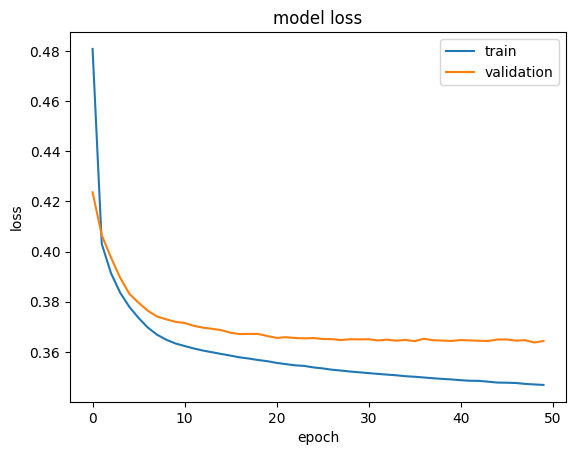

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [25]:
encoder = Model(x, h)

5/5 [==============================] - 0s 6ms/step


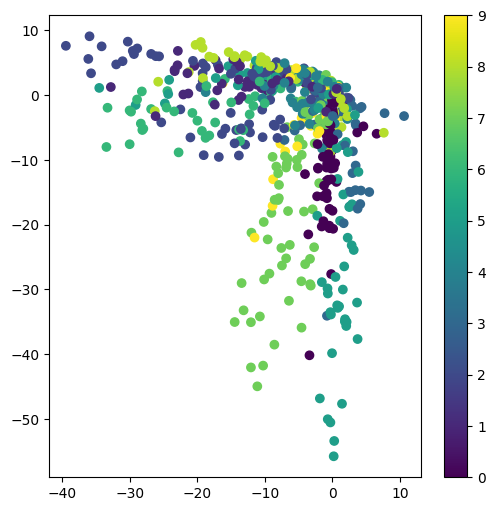

In [26]:
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [64]:
X_test.shape

TensorShape([600, 784])

In [63]:
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

In [84]:
x = Input(shape=(original_dim,))
h = tf.keras.layers.Dense(intermediate_dim, activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(h)
z_log_var = tf.keras.layers.Dense(latent_dim)(h)

In [85]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [86]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

In [87]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [90]:
vae = Model(x, x_decoded_mean)

xent_loss = original_dim * tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_23 (Dense)            (None, 256)                  200960    ['input_7[0][0]']             
                                                                                                  
 dense_24 (Dense)            (None, 2)                    514       ['dense_23[0][0]']            
                                                                                                  
 dense_25 (Dense)            (None, 2)                    514       ['dense_23[0][0]']            
                                                                                           

In [91]:
history = vae.fit(X_train, X_train,shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test))

Epoch 1/50
79/79 [==============================] - 2s 17ms/step - loss: 351.4151 - val_loss: 325.5339
Epoch 2/50
79/79 [==============================] - 1s 15ms/step - loss: 308.7139 - val_loss: 317.8784
Epoch 3/50
79/79 [==============================] - 1s 16ms/step - loss: 302.7178 - val_loss: 308.7249
Epoch 4/50
79/79 [==============================] - 1s 15ms/step - loss: 299.7185 - val_loss: 306.7914
Epoch 5/50
79/79 [==============================] - 2s 25ms/step - loss: 297.5789 - val_loss: 305.0756
Epoch 6/50
79/79 [==============================] - 2s 24ms/step - loss: 296.4038 - val_loss: 303.3804
Epoch 7/50
79/79 [==============================] - 1s 16ms/step - loss: 294.8362 - val_loss: 302.0551
Epoch 8/50
79/79 [==============================] - 1s 17ms/step - loss: 293.8688 - val_loss: 301.6967
Epoch 9/50
79/79 [==============================] - 1s 14ms/step - loss: 293.2041 - val_loss: 300.8760
Epoch 10/50
79/79 [==============================] - 1s 14ms/step - loss:

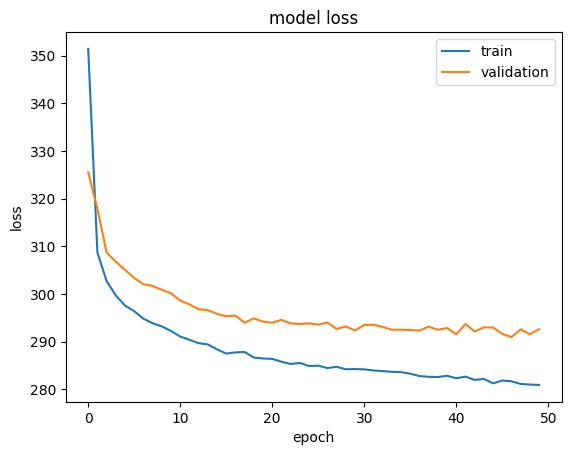

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

5/5 [==============================] - 0s 6ms/step


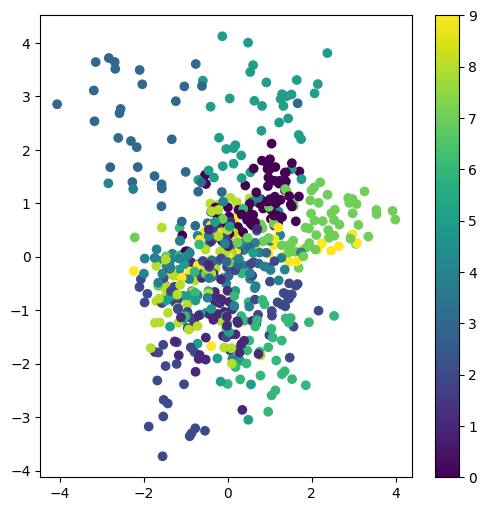

In [93]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [94]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

1/1 [==============================] - 0s 26ms/step


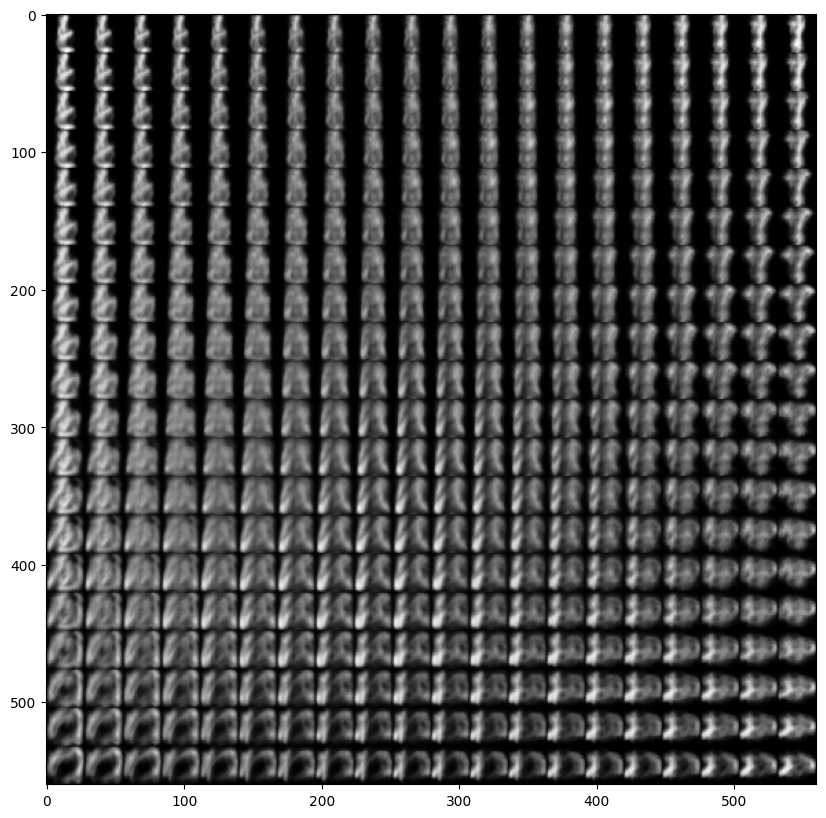

In [96]:
from scipy.stats import norm
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()